# Water Supplies

![](img/barrendiola.jpg)   
$^{1}$Reservoir of Barrendiola (14-07-2022).

Apr, 2023
> *Time series analysis, Networks*

## Background
The reservoir that supplies my county is close to the mountains and gets filled easily if it rains. But its capacity is rather low for the needs of the community and the reservoir empties also easily during dry summers.

Last year the weather was hot and dry, and the scarcity of water was clearly visible throughout the valley. Some days I used to go out for a walk down the path by the river, until I reached a bridge. Then, before turning round and heading back home, I would take a look into the flow of the river. The view from the bridge was depressing: there was very little water running down the stream. It was of no surprise that lately I was not spotting any fish there. The trouts, they were all gone. Like in the old days.

Some decades ago, this used to be an extremely polluted river. Then investments were made to build a complete water management system. It involved the control of the whole water cycle in the basin: the aforementioned reservoir (buffer) upstream, sewage treatment plant downstream, and the regulation and maintenance of an ecological-friendly water flow all along the stream. The idea was to have fauna and flora back in the river again.

But was it working?

Close to the bridge where trouts had disappeared, there is a gauging station where some parameters of the water are regularly monitored. These measurements are available online: https://www.gipuzkoa.eus/es/web/obrahidraulikoak. So I decided to take a look at the data.

![](img/urola.png)

## The data in Aitzu
I downloaded daily water flow rates in the river Urola at the gauging station called Aitzu:
- from **01-07-2022** to **28-02-2023** —8 months.

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import calendar

# Read data from file
aitzu = pd.read_csv("data/aitzu.csv",
                    parse_dates=["date"], index_col="date")

# Convert to m3/s
aitzu["m3/s"] = aitzu["dm3/s"].div(1000)
aitzu = aitzu.drop("dm3/s", axis=1)
print(aitzu)

             m3/s
date             
2022-07-01  0.173
2022-07-02  0.153
2022-07-03  0.146
2022-07-04  0.165
2022-07-05  0.157
...           ...
2023-02-24  2.983
2023-02-25  1.968
2023-02-26  1.740
2023-02-27  1.493
2023-02-28  1.290

[243 rows x 1 columns]


To evaluate those flow rates I needed to compare them to the minimum requirement. After doing some research, I found out that each gauging station is assigned with a minimum water flow rate, called *minimum ecological flow rate* (*[Informe](https://www.uragentzia.euskadi.eus/contenidos/informacion/transparencia_gestion/es_def/adjuntos/Informe_Q_ecologicos_2017_2018.pdf) de seguimiento del grado de cumplimiento de los regímenes de caudales ecológicos. Año hidrológico 2017-2018. Ura, ur agentzia. Agencia vasca del agua. Marzo 2019.*)

These are the monthly values for Aitzu:

In [2]:
# Monthly minimum ecological flowrates for Aitzu
aitzu_min_eco = {"Jan": 0.375, "Feb": 0.375, "Mar": 0.375, "Apr": 0.375,
                 "May": 0.244, "Jun": 0.244,
                 "Jul": 0.156, "Aug": 0.156, "Sep": 0.156, "Oct": 0.156,
                 "Nov": 0.244, "Dec": 0.244}

print(aitzu_min_eco)

{'Jan': 0.375, 'Feb': 0.375, 'Mar': 0.375, 'Apr': 0.375, 'May': 0.244, 'Jun': 0.244, 'Jul': 0.156, 'Aug': 0.156, 'Sep': 0.156, 'Oct': 0.156, 'Nov': 0.244, 'Dec': 0.244}


To facilitate the comparison, I calculate monthly average values of the actual flow rate and plot the results.

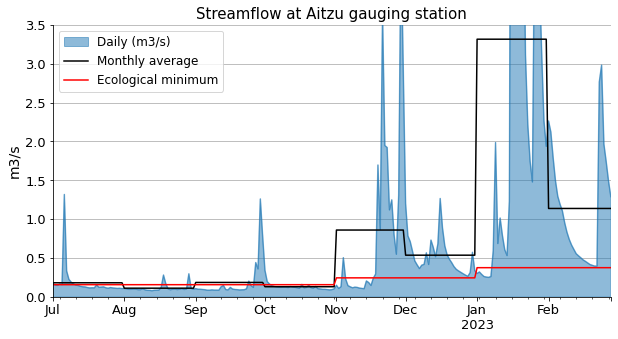

In [3]:
# Convert the data into a pandas dataframe
aitzu_eco = pd.DataFrame(list(aitzu_min_eco.values()),
                         index=list(range(1, 13)), columns=["m3/s"])

# Attach new column in the Aitzu df with monthly minimum ecological flowrate
aitzu["monthly_eco"] = [aitzu_eco["m3/s"][aitzu.index[i].month] for i in range(len(aitzu))]

# Calculate mean value for each month
aitzu_monthly_avg = aitzu.groupby(aitzu.index.month)["m3/s"].mean().to_frame()
aitzu_monthly_avg.index.name = "month"

# Create new column with mean value of the month
aitzu["monthly_avg"] = [aitzu_monthly_avg["m3/s"][aitzu.index[i].month] \
                        for i in range(len(aitzu))]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

aitzu["m3/s"].plot.area(ax=ax, alpha=0.5, label="Daily (m3/s)")
aitzu["monthly_avg"].plot(ax=ax, label="Monthly average", color="black")
aitzu["monthly_eco"].plot(ax=ax, label="Ecological minimum", color="red")

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=13, rotation=0)
ax.tick_params(axis='y', labelsize=13)
ax.set_title("Streamflow at Aitzu gauging station", fontsize=15)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("m3/s", fontsize=14)
ax.set_ylim(0, 3.5)
ax.legend(fontsize=12)
sns.despine()

plt.show()

The graph shows that throughout the last summer and well into the middle of the autumn, the regular flow of water was barely enough to abide by the minimum ecological requirements: the average values in August and October were below the line, and in July and September they were scarcely above.

It looks poor, although not as terrible as I thought. However, the fish disapeared, I can assure you. Maybe there were other reasons, but reaching the minimum ecological flow requirements seems necessary to preserve natural life. 

Now the question was:
- Would it have been possible to get the needed extra water from the reservoir?

(I am going to assume that there are no losses between the reservoir and the gauging station, which is located several kilometres downstream. This is not realistic, but I will assume that for simplicity —and because I have no idea how much would losses account for).

In [4]:
# Calculate additional flow rate needed to reach ecological minimum
deltas = []
efficiency = 1.0

for i in aitzu_monthly_avg.index:
    delta = aitzu_eco["m3/s"][i] - aitzu_monthly_avg["m3/s"][i]
    if delta > 0:
        deltas.append(delta / efficiency)
        print(f"In {calendar.month_abbr[i]} -> {delta / efficiency:.3f} m3/s extra needed")
    else:
        deltas.append(0)
        
# Insert new column with the water flow needed from Barrendiola
aitzu_monthly_avg["barren_m3/s"] = deltas

In Aug -> 0.045 m3/s extra needed
In Oct -> 0.026 m3/s extra needed


Let's see how this extra demand for water would have affected the volumes of the reservoir.

## The data in Barrendiola
I downloaded the information about the evolution of the water reserves in the reservoir in this website: https://www.gipuzkoakour.eus/   

In [5]:
# Read data from file
barrendiola = pd.read_csv("data/barrendiola.csv",
                          parse_dates=["date"], index_col="date")
print(barrendiola.head())

             hm3  normal  prealerta  alerta  emergencia  lowest
date                                                           
2022-06-23  1.32    1.48       1.40    1.33        1.26    1.21
2022-07-03  1.25    1.48       1.37    1.27        1.20    1.13
2022-07-13  1.22    1.48       1.34    1.23        1.13    1.07
2022-07-23  1.16    1.48       1.30    1.17        1.09    1.00
2022-08-02  1.11    1.48       1.26    1.12        1.03    0.93


As the data was not available daily, I had to interpolate the values to fill in the gaps.

The following graph shows the evolution of the water volume, the actual one and in the hypothetical case the extra water had been extracted.

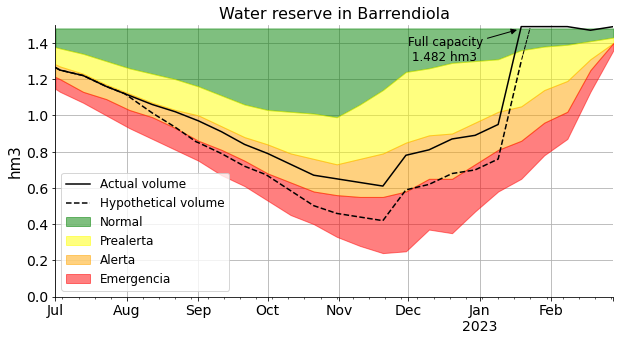

In [13]:
# Set frequency as daily and interpolate to fill in gaps
barrendiola = barrendiola.asfreq("D").interpolate()

# Select values from Jul 2022 to end of Feb 2023
barrendiola = barrendiola[(barrendiola.index >= "2022-07-01") \
                          & (barrendiola.index <= "2023-02-28")]

# Create new column with demanded flow output
barrendiola["m3/s_out"] = [aitzu_monthly_avg["barren_m3/s"][barrendiola.index[i].month] \
                        for i in range(len(barrendiola))]

# Create new column with demanded volume output
barrendiola["hm3_out"] = barrendiola["m3/s_out"] * 60 * 60 * 24 / 1000000

# Create new column with accumulated volume output
barrendiola["hm3_out_cum"] = barrendiola["hm3_out"].cumsum()

# Create new column with hypothetical reservoir volumes
barrendiola["hm3_new"] = barrendiola["hm3"] - barrendiola["hm3_out_cum"]

# Locate and reassign values when reservoir is full
barrendiola.loc[barrendiola.index >= "2023-01-20", "hm3_new"] = np.nan

#Plot
fig, ax = plt.subplots(figsize=(10, 5))

barrendiola["hm3"].plot(ax=ax, color="black", label="Actual volume")
barrendiola["hm3_new"].plot(ax=ax, color="black", label="Hypothetical volume", linestyle="--")

ax.fill_between(barrendiola.index,
                barrendiola["prealerta"], barrendiola["normal"],
                color="green", alpha=0.5, label="Normal")

ax.fill_between(barrendiola.index,
                barrendiola["alerta"], barrendiola["prealerta"],
                color="yellow", alpha=0.5, label="Prealerta")

ax.fill_between(barrendiola.index,
                barrendiola["emergencia"], barrendiola["alerta"],
                color="orange", alpha=0.5, label="Alerta")

ax.fill_between(barrendiola.index,
                barrendiola["lowest"], barrendiola["emergencia"],
                color="red", alpha=0.5, label="Emergencia")

ax.grid(axis="both")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel("")
ax.set_title("Water reserve in Barrendiola", size=16)
ax.set_ylabel("hm3", size=15)
ax.set_ylim(0, 1.5)
sns.despine()

barrendiola_full = 1.482 # Full capacity of Barrendiola in hm3

ax.annotate(f"Full capacity\n {barrendiola_full} hm3",
            xy=("2023-01-18", 1.475), 
            xytext=("2022-12-01", 1.3), fontsize=12,
            arrowprops={"arrowstyle":"-|>", "color":"black"})

ax.annotate("",
            xy=("2023-01-23", 1.49), 
            xytext=("2023-01-19", 1.299), fontsize=12,
            arrowprops={"arrowstyle":"-", "linestyle":"--", "color":"black"})

ax.legend(fontsize=12)

plt.show()

The difference is remarkable! Initially it did not seem we were asking for so much water, but definitely it affects the water reserves in an already limited reservoir that just barely meets the needs of the community.

## Stream-in Barrendiola

The main stream that feeds Barrendiola has a gauging station right before the entrance to the reservoir. I downloaded the data to see how much water was provided during the time period. I also took a look at the rainfall during those months.

In [7]:
# Read data from file
barrendiola_in = pd.read_csv("data/barrendiola-in.csv",
                             parse_dates=["date"], index_col="date")

# Convert to m3/s
barrendiola_in["m3/s"] = barrendiola_in["dm3/s"] / 1000
barrendiola_in = barrendiola_in.drop("dm3/s", axis=1)

print(barrendiola_in)

            rainfall   m3/s
date                       
2022-07-01       0.0  0.012
2022-07-02       0.0  0.012
2022-07-03       3.4  0.010
2022-07-04       1.3  0.010
2022-07-05       0.3  0.009
...              ...    ...
2023-02-24       8.8  0.078
2023-02-25       2.4  0.074
2023-02-26       1.5  0.078
2023-02-27       0.1  0.067
2023-02-28       5.4  0.059

[243 rows x 2 columns]


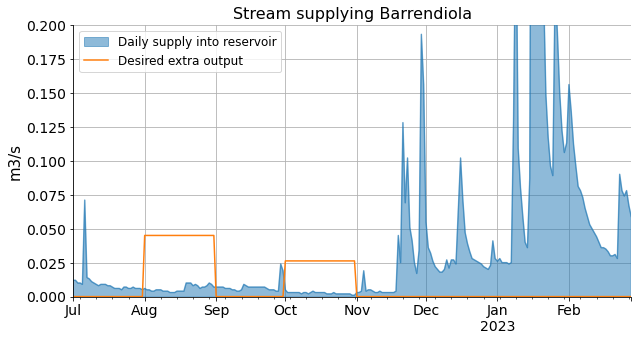

In [14]:
#Plot
fig, ax = plt.subplots(figsize=(10, 5))

barrendiola_in["m3/s"].plot.area(ax=ax, alpha=0.5,
                             label="Daily supply into reservoir")

barrendiola["m3/s_out"].plot(ax=ax,
                             label="Desired extra output")

ax.grid(axis="both")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel("")
ax.set_title("Stream supplying Barrendiola", size=16)
ax.set_ylabel("m3/s", size=15)
ax.set_ylim(0, 0.2)
ax.legend(fontsize=12)
sns.despine()

plt.show()

The graph clearly shows that the stream by itself cannot cope with the extra amount that is being asked.

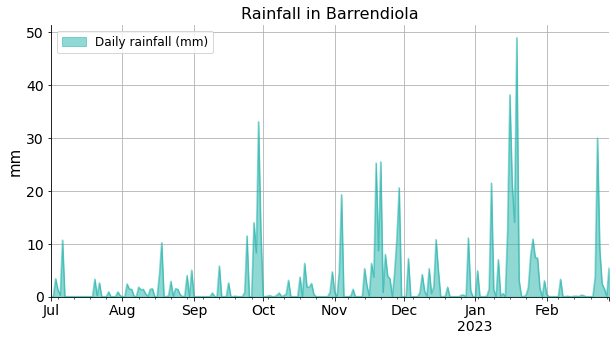

In [15]:
#Plot
fig, ax = plt.subplots(figsize=(10, 5))

barrendiola_in["rainfall"].plot.area(ax=ax, color="lightseagreen",
                                     alpha=0.5, label="Daily rainfall (mm)")
 
ax.grid(axis="both")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel("")
ax.set_title("Rainfall in Barrendiola", size=16)
ax.set_ylabel("mm", size=15)
ax.legend(fontsize=12)
sns.despine()

plt.show()

Rainfall is depicted just for information. Rain is also contributing to the reservoir, it is hard to say to what extend though. Also, when it rains, several other streams flow into the reservoir making it even more difficult to deduce the amounts.

Does the reservoir have any other source of water?

Yes, it has!

## The reservoir network
To respond to emergency demands, various reservoirs in the province were connected between each other.

![](img/embalses.png)

In [10]:
# Parameters of the reservoirs
reservoirs_dic = {"reservoir": ["Aixola", "Barrendiola",
                                "Urkulu", "Lareo", "Ibai-eder",
                                "Arriaran", "Ibiur"],
                  "vol_hm3": [2.726, 1.482, 10, 2.23, 11.3, 3.013, 7.575],
                  "alt_m": [306, 543, 328, 740, 221, 281, 162]}

# Convert to dafaframe
reservoirs = pd.DataFrame(reservoirs_dic)\
            .sort_values("vol_hm3", ascending=False).set_index("reservoir")

print(reservoirs)

             vol_hm3  alt_m
reservoir                  
Ibai-eder     11.300    221
Urkulu        10.000    328
Ibiur          7.575    162
Arriaran       3.013    281
Aixola         2.726    306
Lareo          2.230    740
Barrendiola    1.482    543


In the list above, we can see that Barrendiola is the smallest reservoir at the group. And the one that is connected to, Ibai-eder, the biggest one.

In [11]:
# Connections
connections_dic = {"from": ["Ibai-eder", "Arriaran", "Arriaran", "Urkulu"],
                   "to":["Barrendiola", "Lareo", "Ibiur", "Aixola"],
                   "km": [15.9, 14.5, 9.3, 15.3]}

# Convert to dafaframe
connections = pd.DataFrame(connections_dic)

print(connections)

        from           to    km
0  Ibai-eder  Barrendiola  15.9
1   Arriaran        Lareo  14.5
2   Arriaran        Ibiur   9.3
3     Urkulu       Aixola  15.3


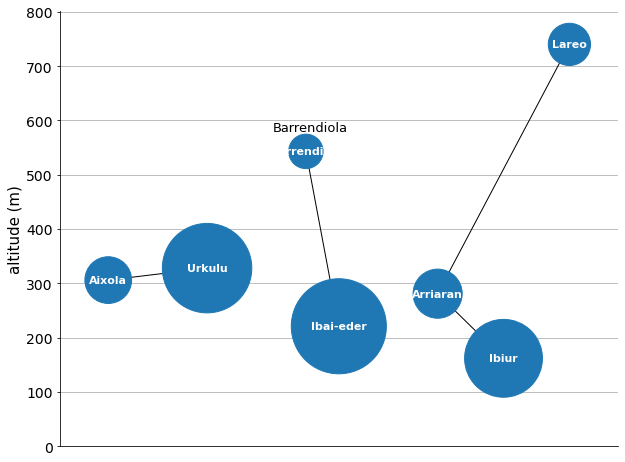

In [12]:
# Import network package
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes
for i in range(len(reservoirs)):
    G.add_node(reservoirs.index[i],
               vol_hm3=reservoirs["vol_hm3"][i],
               alt_m=reservoirs["alt_m"][i])

# # Show nodes with metadata
# G.nodes(data=True)

# Add edges
for i in range(len(connections)):
    G.add_edge(connections["from"][i], connections["to"][i],
               dist_km=connections["km"][i],
               alt_diff=abs(reservoirs.loc[connections["from"][i]]["alt_m"] \
                            - reservoirs.loc[connections["to"][i]]["alt_m"]))

# # Show edges with metadata
# G.edges(data=True)

# Node size proportional to reservoir volume
node_size = [G.nodes[i]["vol_hm3"] for i in G.nodes()]
scale = 800 # default 300
node_size_scaled = reservoirs["vol_hm3"] * scale

# Layout of the graph
pos_x = [3.5, 1.5, 6, 5, 0, 7, 3]
pos = {n: (x, G.nodes[n]["alt_m"]) for n, x in zip(G.nodes(), pos_x)}

# Edge list
edgelist = [(u, v) for (u, v) in G.edges()]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

nx.draw_networkx_nodes(G, pos=pos, ax=ax,
                       node_size=node_size_scaled)

nx.draw_networkx_labels(G, pos, ax=ax, font_size=11,
                        font_weight="bold", font_color="white")

nx.draw_networkx_edges(G, pos, ax=ax, node_size=node_size,
                       edgelist=edgelist, width=1)

# nx.draw_networkx_edge_labels(G, pos, ax=ax,
#                             edge_labels=nx.get_edge_attributes(G, "dist_km"),
#                             font_size=10)
 
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel("altitude (m)", size=15)
ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)
ax.set_ylim(0)
ax.text(2.5, 580, "Barrendiola", fontsize=13)
sns.despine()

plt.show()

So this is how I imagine the system: Barrendiola, which is located close to the mountains and at a relatively high altitude, gets a lot of water during the winter and spring. As it is small, it gets full easily and lets through a lot of water. This exceeding water could therefore be stored in the large Ibai-eder reservoir. Then, during the summers and autumns, Ibai-eder would give back to Barrendiola some of its water. And maybe, that way there would be enough resources to maintain a minimum ecological flow rate in the river Urola.

But I do not know about all this. Unfortunately, I was not able to get any information about water transfers between reservoirs. I suppose there are constraints also, and associated energy costs as well.

## Conclusion

In this project I analysed the data available online to learn about the figures relating the water supply in my community. The system looks quite limited in capacity for the dry months, especially considering the climate change and the hotter and presumably drier summers expected in the future. I hope that there is some plan on the part of the local governments to ensure a minimum flow that allows there to be fish in the river in a sustainable manner. I am going to miss the trouts otherwise.